In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
train = pd.read_csv('../../DATA/titanic_train.csv')
test = pd.read_csv('../../DATA/titanic_test.csv')
print(train.shape, test.shape)

(891, 12) (418, 11)


In [51]:
train = pd.concat([train, test],axis=0)
print(train.shape)
train.head()

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


In [53]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,1309.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.000,1.0000
Pclass,1309.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
Age,1046.0,29.881138,14.413493,0.17,21.0000,28.0000,39.000,80.0000
SibSp,1309.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
Parch,1309.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
Fare,1308.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292


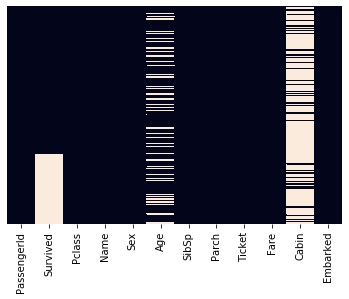

In [54]:
sns.heatmap(train.isnull(), yticklabels=False, cbar=False)

In [55]:
def imputeAge(columns):
    age = columns[1]
    Pclass = columns[0]
    if pd.isnull(age):
        if Pclass==1:
            return round(train[train['Pclass']==1]['Age'].mean(),1)
        elif Pclass==2:
            return round(train[train['Pclass']==2]['Age'].mean(),1)
        else:
            return round(train[train['Pclass']==3]['Age'].mean(),1)
    else:
        return age

In [56]:
print(train['Age'].tail())
print('\n')
train['Age'] = train[['Pclass', 'Age']].apply(imputeAge, axis=1)
print(train['Age'].tail())

413     NaN
414    39.0
415    38.5
416     NaN
417     NaN
Name: Age, dtype: float64


413    24.8
414    39.0
415    38.5
416    24.8
417    24.8
Name: Age, dtype: float64


In [57]:
drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train.drop(labels=drop_columns, axis=1, inplace=True)
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [58]:
print(train.shape)
print('\n')
print(train[pd.isnull(train['Embarked'])])  # droping these two nan entries 
train.dropna(inplace=True)
print(train.shape)

(1309, 8)


     Survived  Pclass     Sex   Age  SibSp  Parch  Fare Embarked
61        1.0       1  female  38.0      0      0  80.0      NaN
829       1.0       1  female  62.0      0      0  80.0      NaN
(889, 8)


In [59]:
sex = pd.get_dummies(data=train['Sex'], drop_first=True)
embarked = pd.get_dummies(data=train['Embarked'], drop_first=True)
train = pd.concat([train, sex, embarked], axis=1)
train.drop(['Sex', 'Embarked'], axis=1, inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0.0,3,22.0,1,0,7.2500,1,0,1
1,1.0,1,38.0,1,0,71.2833,0,0,0
2,1.0,3,26.0,0,0,7.9250,0,0,1
3,1.0,1,35.0,1,0,53.1000,0,0,1
4,0.0,3,35.0,0,0,8.0500,1,0,1


In [61]:
# sns.heatmap(train.isnull())

### Building ML models

In [64]:
X = train.drop('Survived', axis=1).values
y = train['Survived'].values

X_train, X_test, y_train, y_test = train_test_split(train.drop('Survived',axis=1), 
                                                    train['Survived'], test_size=0.30, 
                                                    random_state=42)

In [65]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/home/dhrumpy/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
y_pred = logmodel.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84       167
         1.0       0.73      0.75      0.74       100

    accuracy                           0.80       267
   macro avg       0.79      0.79      0.79       267
weighted avg       0.80      0.80      0.80       267



In [70]:
confusion_matrix(y_test, y_pred)

array([[139,  28],
       [ 25,  75]])

### Building ANN

In [96]:
classifier = Sequential()
classifier.add(Dense(units=10, activation='relu', input_dim=X_train.shape[1]))
classifier.add(Dense(units=6, activation='relu'))
classifier.add(Dense(units=4, activation='relu'))
classifier.add(Dense(units=1, activation='sigmoid'))

classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [97]:
classifier.fit(X_train,y_train, batch_size=128, validation_data = (X_test, y_test), 
               epochs=50, callbacks=[early_stop], verbose=2)

Train on 622 samples, validate on 267 samples
Epoch 1/50
622/622 - 1s - loss: 1.9957 - accuracy: 0.6093 - val_loss: 1.7222 - val_accuracy: 0.6255
Epoch 2/50
622/622 - 0s - loss: 1.7112 - accuracy: 0.6125 - val_loss: 1.4974 - val_accuracy: 0.6255
Epoch 3/50
622/622 - 0s - loss: 1.4617 - accuracy: 0.6141 - val_loss: 1.2783 - val_accuracy: 0.6255
Epoch 4/50
622/622 - 0s - loss: 1.2430 - accuracy: 0.6141 - val_loss: 1.0839 - val_accuracy: 0.6255
Epoch 5/50
622/622 - 0s - loss: 1.0395 - accuracy: 0.6141 - val_loss: 0.9103 - val_accuracy: 0.6255
Epoch 6/50
622/622 - 0s - loss: 0.8711 - accuracy: 0.6125 - val_loss: 0.7665 - val_accuracy: 0.6217
Epoch 7/50
622/622 - 0s - loss: 0.7424 - accuracy: 0.5997 - val_loss: 0.6853 - val_accuracy: 0.6404
Epoch 8/50
622/622 - 0s - loss: 0.6881 - accuracy: 0.6141 - val_loss: 0.6522 - val_accuracy: 0.6854
Epoch 9/50
622/622 - 0s - loss: 0.6594 - accuracy: 0.6431 - val_loss: 0.6458 - val_accuracy: 0.6929
Epoch 10/50
622/622 - 0s - loss: 0.6513 - accuracy: 0.

In [98]:
model_loss = pd.DataFrame(classifier.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,1.995682,0.609325,1.722242,0.625468
1,1.711171,0.612540,1.497362,0.625468
2,1.461678,0.614148,1.278294,0.625468
3,1.243030,0.614148,1.083921,0.625468
4,1.039520,0.614148,0.910314,0.625468


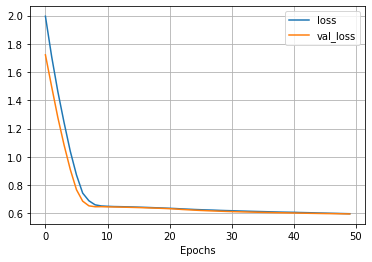

In [99]:
ax = model_loss.loc[:, ['loss', 'val_loss']].plot(grid=True);
ax.set_xlabel('Epochs');
# model_loss.loc[:, ['accuracy', 'val_accuracy']].plot(grid=True)

In [100]:
y_pred = classifier.predict_classes(X_test) 
print(classification_report(y_test,y_pred))
confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

         0.0       0.72      0.85      0.78       167
         1.0       0.64      0.44      0.52       100

    accuracy                           0.70       267
   macro avg       0.68      0.65      0.65       267
weighted avg       0.69      0.70      0.68       267



array([[142,  25],
       [ 56,  44]])